In [1]:
# ==============================
# Personal Finance Spending Analyzer (Google Colab)
# Author: Anirudh Bhamidipati
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ------------------------------
# 1) Generate a synthetic "bank transactions" dataset
#    (This keeps the project doable and reproducible.)
# ------------------------------

np.random.seed(42)

n_rows = 600  # ~600 transactions
dates = pd.date_range("2024-01-01", "2024-12-31", freq="D")
sample_dates = np.random.choice(dates, size=n_rows, replace=True)

merchants = [
    ("Whole Foods", "Groceries"),
    ("Trader Joe's", "Groceries"),
    ("Chipotle", "Dining"),
    ("Sweetgreen", "Dining"),
    ("Starbucks", "Dining"),
    ("Amazon", "Shopping"),
    ("Target", "Shopping"),
    ("Uber", "Transport"),
    ("Lyft", "Transport"),
    ("Exxon", "Gas"),
    ("Shell", "Gas"),
    ("ConEd", "Utilities"),
    ("Verizon", "Utilities"),
    ("Netflix", "Subscriptions"),
    ("Spotify", "Subscriptions"),
    ("Planet Fitness", "Subscriptions"),
    ("CVS", "Health"),
    ("Walgreens", "Health"),
    ("Rent Payment", "Housing"),
    ("Paycheck", "Income"),
]

# Create random transactions
rows = []
for _ in range(n_rows):
    d = pd.to_datetime(np.random.choice(sample_dates))
    merchant, category = merchants[np.random.randint(0, len(merchants))]

    # Income is positive, expenses are negative
    if category == "Income":
        amount = np.random.randint(1200, 2600)  # paycheck
    elif category == "Housing":
        amount = -np.random.randint(1200, 2200) # rent
    elif category in ["Groceries", "Dining", "Shopping"]:
        amount = -round(np.random.uniform(8, 180), 2)
    elif category in ["Transport", "Gas"]:
        amount = -round(np.random.uniform(10, 90), 2)
    elif category in ["Subscriptions"]:
        amount = -round(np.random.uniform(8, 35), 2)
    elif category in ["Utilities"]:
        amount = -round(np.random.uniform(40, 180), 2)
    else:  # Health
        amount = -round(np.random.uniform(6, 120), 2)

    rows.append([d, merchant, category, amount])

df = pd.DataFrame(rows, columns=["date", "merchant", "category", "amount"])
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

# Optional: Save to CSV so it looks like a real project asset
df.to_csv("sample_transactions.csv", index=False)

df.head()


,date,merchant,category,amount
0,2024-01-01,Verizon,Utilities,-149.18
1,2024-01-02,Uber,Transport,-67.13
2,2024-01-02,Trader Joe's,Groceries,-146.51
3,2024-01-02,Target,Shopping,-137.56
4,2024-01-02,Starbucks,Dining,-114.69


In [3]:
# ------------------------------
# 2) Basic cleaning + feature engineering
# ------------------------------

df["month"] = df["date"].dt.to_period("M").astype(str)

# Split income vs expense
df["income"] = df["amount"].where(df["amount"] > 0, 0)
df["expense"] = df["amount"].where(df["amount"] < 0, 0)  # expenses are negative

df.describe(include="all")

,date,merchant,category,amount,month,income,expense
count,600,600,600,600.00000,600,600.000000,600.000000
unique,NaN,20,10,NaN,12,NaN,NaN
top,NaN,Rent Payment,Dining,NaN,2024-08,NaN,NaN
freq,NaN,39,98,NaN,76,NaN,NaN
mean,2024-07-11 11:09:36,NaN,NaN,-86.03580,NaN,85.661667,-171.697467
min,2024-01-01 00:00:00,NaN,NaN,-2135.00000,NaN,0.000000,-2135.000000
25%,2024-04-16 12:00:00,NaN,NaN,-111.56750,NaN,0.000000,-111.567500
50%,2024-07-16 00:00:00,NaN,NaN,-63.27000,NaN,0.000000,-63.270000
75%,2024-10-09 00:00:00,NaN,NaN,-25.38250,NaN,0.000000,-25.382500
max,2024-12-31 00:00:00,NaN,NaN,2541.00000,NaN,2541.000000,0.000000


In [4]:
# ------------------------------
# 3) Monthly summary
# ------------------------------

monthly = df.groupby("month").agg(
    total_income=("income", "sum"),
    total_expense=("expense", "sum"),
    net_cashflow=("amount", "sum"),
    transactions=("amount", "count")
).reset_index()

# Convert expense to positive for easier reading
monthly["total_expense_abs"] = monthly["total_expense"].abs()

# Savings rate (net / income)
monthly["savings_rate"] = np.where(
    monthly["total_income"] > 0,
    monthly["net_cashflow"] / monthly["total_income"],
    np.nan
)

monthly


,month,total_income,total_expense,net_cashflow,transactions,total_expense_abs,savings_rate
0,2024-01,4640.0,-5400.25,-760.25,27,5400.25,-0.163847
1,2024-02,7962.0,-6604.35,1357.65,49,6604.35,0.170516
2,2024-03,2004.0,-12296.81,-10292.81,48,12296.81,-5.136133
3,2024-04,4654.0,-11727.62,-7073.62,50,11727.62,-1.519901
4,2024-05,4950.0,-7847.74,-2897.74,62,7847.74,-0.585402
5,2024-06,6117.0,-2410.86,3706.14,41,2410.86,0.605875
6,2024-07,1329.0,-8891.68,-7562.68,37,8891.68,-5.690504
7,2024-08,2336.0,-20903.58,-18567.58,76,20903.58,-7.948450
8,2024-09,6174.0,-2879.15,3294.85,46,2879.15,0.533665
9,2024-10,3711.0,-9553.37,-5842.37,52,9553.37,-1.574338


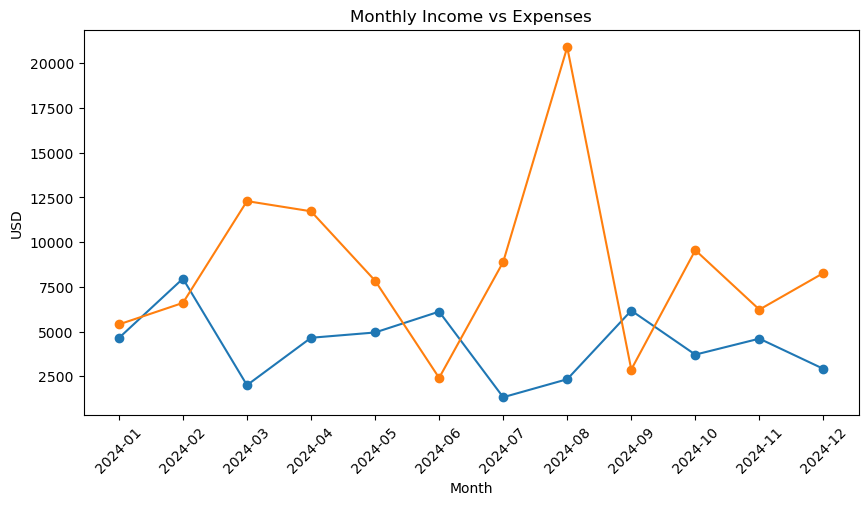

In [5]:
# ------------------------------
# 4) Visualize income vs expenses
# ------------------------------

plt.figure(figsize=(10,5))
plt.plot(monthly["month"], monthly["total_income"], marker="o")
plt.plot(monthly["month"], monthly["total_expense_abs"], marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Income vs Expenses")
plt.ylabel("USD")
plt.xlabel("Month")
plt.show()


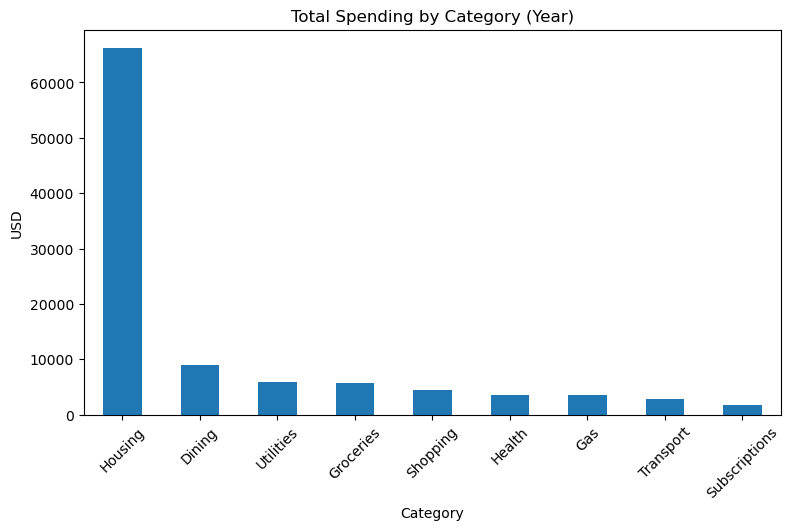

category,Dining,Gas,Groceries,Health,Housing,Shopping,Subscriptions,Transport,Utilities
month,,,,,,,,,
2024-01,415.20,16.84,155.81,370.66,3701.0,137.56,89.32,190.91,322.95
2024-02,451.83,79.44,557.93,194.59,3850.0,279.15,121.51,117.95,951.95
2024-03,631.88,400.97,200.01,139.33,9787.0,456.63,139.83,32.31,508.85
2024-04,1111.86,97.15,583.81,297.14,8693.0,180.86,98.80,257.68,407.32
2024-05,829.30,474.20,310.71,217.43,4355.0,575.20,94.84,365.96,625.10


In [6]:
# ------------------------------
# 5) Category breakdown (overall + monthly)
# ------------------------------

# Overall spending by category (expenses only)
spend_by_cat = (
    df[df["amount"] < 0]
    .groupby("category")["amount"]
    .sum()
    .abs()
    .sort_values(ascending=False)
)

spend_by_cat

plt.figure(figsize=(9,5))
spend_by_cat.plot(kind="bar")
plt.title("Total Spending by Category (Year)")
plt.ylabel("USD")
plt.xlabel("Category")
plt.xticks(rotation=45)
plt.show()

# Monthly spending by category (heatmap-like pivot table)
monthly_cat = (
    df[df["amount"] < 0]
    .groupby(["month", "category"])["amount"]
    .sum()
    .abs()
    .reset_index()
    .pivot(index="month", columns="category", values="amount")
    .fillna(0)
)

monthly_cat.head()


In [7]:
# 6) Simple "Red Flag" Insights
# ------------------------------

insights = []

# A) Top 3 spending categories
top3 = spend_by_cat.head(3)
insights.append("Top spending categories:")
for cat, val in top3.items():
    insights.append(f" - {cat}: ${val:,.2f}")

# B) Highest expense month
max_exp_idx = monthly["total_expense_abs"].idxmax()
max_exp_month = monthly.loc[max_exp_idx, "month"]
max_exp_val = monthly.loc[max_exp_idx, "total_expense_abs"]
insights.append(f"\nHighest spending month: {max_exp_month} (${max_exp_val:,.2f})")

# C) Subscription creep (spending trend)
if "Subscriptions" in monthly_cat.columns:
    sub_avg = monthly_cat["Subscriptions"].mean()
    sub_last3 = monthly_cat["Subscriptions"].tail(3).mean()
    if sub_last3 > sub_avg * 1.25:
        insights.append("\n⚠ Subscription spending increased significantly in the last 3 months.")

# D) Low savings rate months
low_savings = monthly[monthly["savings_rate"] < 0.10]  # < 10%
if len(low_savings) > 0:
    months_list = ", ".join(low_savings["month"].tolist())
    insights.append(f"\n⚠ Low savings rate (<10%) in: {months_list}")

print("\n".join(insights))


Top spending categories:
 - Housing: $66,202.00
 - Dining: $8,976.27
 - Utilities: $5,956.62

Highest spending month: 2024-08 ($20,903.58)

⚠ Subscription spending increased significantly in the last 3 months.

⚠ Low savings rate (<10%) in: 2024-01, 2024-03, 2024-04, 2024-05, 2024-07, 2024-08, 2024-10, 2024-11, 2024-12


In [8]:
# ------------------------------
# 7) Stakeholder-friendly summary (for recruiters)
# ------------------------------

summary = f"""
Summary (Stakeholder View)
--------------------------
- Time period analyzed: {df['date'].min().date()} to {df['date'].max().date()}
- Total income:  ${monthly['total_income'].sum():,.2f}
- Total spend:   ${monthly['total_expense_abs'].sum():,.2f}
- Net cashflow:  ${monthly['net_cashflow'].sum():,.2f}
- Avg savings rate: {monthly['savings_rate'].mean()*100:.1f}%

Key Insight:
- The largest spending categories are {', '.join(top3.index.tolist())}.
- The highest spending month was {max_exp_month}.
"""

print(summary)




Summary (Stakeholder View)
--------------------------
- Time period analyzed: 2024-01-01 to 2024-12-31
- Total income:  $51,397.00
- Total spend:   $103,018.48
- Net cashflow:  $-51,621.48
- Avg savings rate: -195.8%

Key Insight:
- The largest spending categories are Housing, Dining, Utilities.
- The highest spending month was 2024-08.

